In [1]:
import numpy as np

near_ids = np.load('partial_near_ids_scope_test_v_lookup.npy', allow_pickle=True)


Text(0.5, 1.0, '# of Exact matches by similarity score')

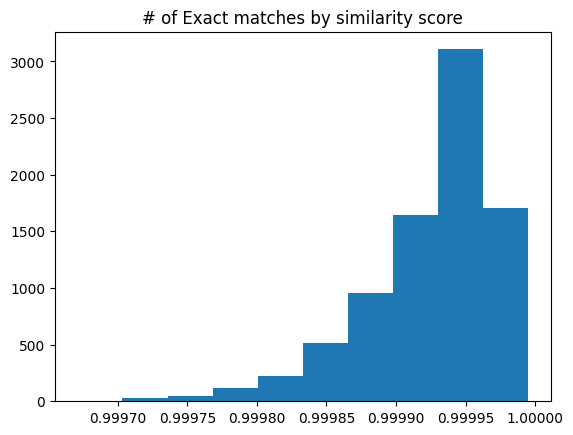

In [13]:
from scope_utils import get_sims_labels
import matplotlib.pyplot as plt

sims, labels = get_sims_labels(near_ids, partial=False)
plt.hist(np.array(sims)[np.array(labels).astype(bool)]) # plot exact matches as a function of their similarity score
plt.title('# of Exact matches by similarity score')

Text(0.5, 1.0, '# of Partial matches by similarity score')

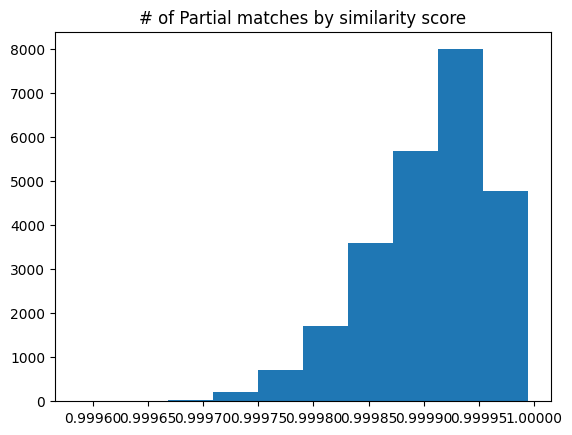

In [14]:
## Now, we plot partial matches as well (i.e.: those that have different families but same superfamily)

sims, labels = get_sims_labels(near_ids, partial=True)
plt.hist(np.array(sims)[np.array(labels).astype(bool)]) # plot exact matches as a function of their similarity score
plt.title('# of Partial matches by similarity score')

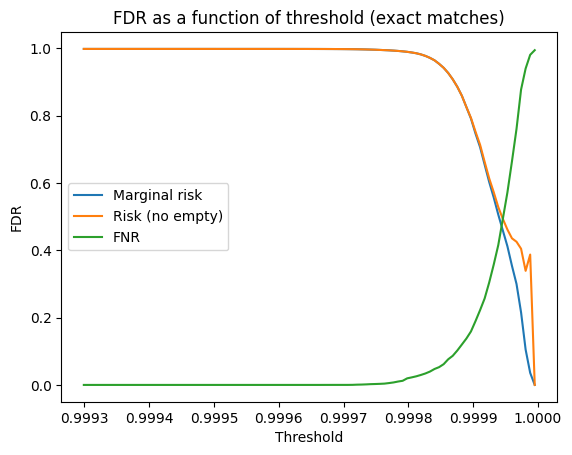

In [15]:
# Now, lets compute the exact FDR curve

from scope_utils import risk_no_empties, calculate_false_negatives, risk

plt.figure()
# Plot FDR as a function of lambda
# sims, labels = get_sims_labels(data, partial=False)
labels = np.stack([query['exact'] for query in near_ids], axis=0)
sims = np.stack([query['S_i'] for query in near_ids], axis=0)
lambdas = np.linspace(sims.min(),sims.max(),100)
risks = [risk(sims, labels, lam) for lam in lambdas]
risks_no_empties = [risk_no_empties(sims, labels, lam) for lam in lambdas]
# percentage_of_discoveries_rsk = [percentage_of_discoveries(sims, labels, lam) for lam in lambdas]
fnr = [calculate_false_negatives(sims, labels, lam) for lam in lambdas]
plt.plot(lambdas, risks, label='Marginal risk')
plt.plot(lambdas, risks_no_empties, label='Risk (no empty)')
# plt.plot(lambdas, percentage_of_discoveries_rsk, label='Percentage of discoveries')
plt.plot(lambdas, fnr, label='FNR')
plt.xlabel('Threshold')
plt.ylabel('FDR')
plt.title('FDR as a function of threshold (exact matches)')
plt.legend()
plt.show()

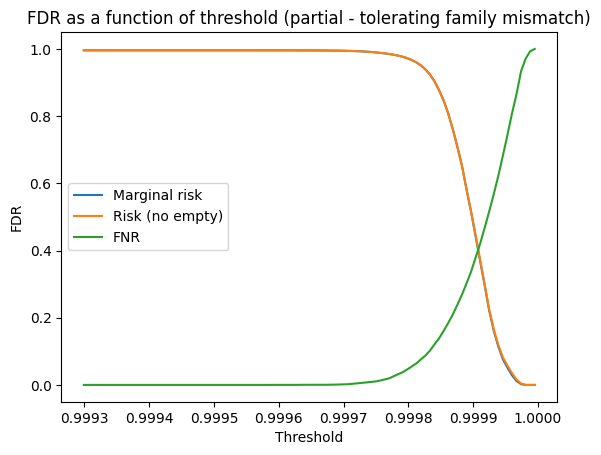

In [16]:
plt.figure()
# Plot FDR as a function of lambda
# sims, labels = get_sims_labels(data, partial=False)
labels = np.stack([query['partial'] for query in near_ids], axis=0)
sims = np.stack([query['S_i'] for query in near_ids], axis=0)
lambdas = np.linspace(sims.min(),sims.max(),100)
risks = [risk(sims, labels, lam) for lam in lambdas]
risks_no_empties = [risk_no_empties(sims, labels, lam) for lam in lambdas]
# percentage_of_discoveries_rsk = [percentage_of_discoveries(sims, labels, lam) for lam in lambdas]
fnr = [calculate_false_negatives(sims, labels, lam) for lam in lambdas]
plt.plot(lambdas, risks, label='Marginal risk')
plt.plot(lambdas, risks_no_empties, label='Risk (no empty)')
# plt.plot(lambdas, percentage_of_discoveries_rsk, label='Percentage of discoveries')
plt.plot(lambdas, fnr, label='FNR')
plt.xlabel('Threshold')
plt.ylabel('FDR')
plt.title('FDR as a function of threshold (partial - tolerating family mismatch)')
plt.legend()
plt.show()

In [17]:
losses = [x['loss'] for x in near_ids]
losses = [item for sublist in losses for item in sublist]
losses = np.array(losses).reshape(400, 14777)

### Plot distribution of similarity scores for different retrieval thresholds
#### Loss explanation
3 - Retrieves a protein with different family, superfamily, and fold (but same class)

2 - Retrieves a protein with different family, superfamily (but same fold, class)

1 - Retrieves a protein with different family, (same superfamily, fold, class)

0 - exact match

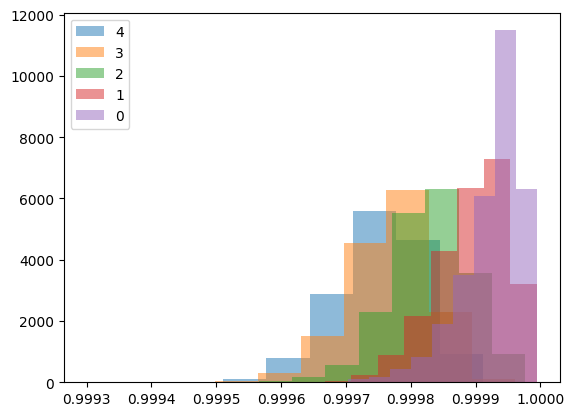

In [19]:
plt.hist(np.array(sims)[np.array(losses == 4).astype(bool)], density=True, alpha=0.5, label='4') # plot exact matches as a function of their similarity score, color by loss
plt.hist(np.array(sims)[np.array(losses == 3).astype(bool)], density=True, alpha=0.5, label='3') # plot exact matches as a function of their similarity score, color by loss
plt.hist(np.array(sims)[np.array(losses == 2).astype(bool)], density=True, alpha=0.5, label='2') # plot exact matches as a function of their similarity score, color by loss
plt.hist(np.array(sims)[np.array(losses == 1).astype(bool)], density=True, alpha=0.5, label='1') # plot exact matches as a function of their similarity score, color by loss
plt.hist(np.array(sims)[np.array(losses == 0).astype(bool)], density=True, alpha=0.5, label='0') # plot exact matches as a function of their similarity score, color by loss
plt.legend()

### Run conformal procedure

For now, we use 300 to calibrate, 100 to test on. We use the exact matches as labels (for now).
Still need to do a plot of the loss density by height, but the above plots looking at similarity thresholds give a sense of how the scores consistently shift rightwards as you constrain the lambda/cutoff to be higher and higher.

In [8]:
from scope_utils import get_thresh_FDR

labels = np.stack([query['exact'] for query in near_ids], axis=0)
sims = np.stack([query['S_i'] for query in near_ids], axis=0)


alpha = 0.1
lhat = get_thresh_FDR(labels, sims, alpha, delta=0.5, N=100)

sims.max: 0.9999949336051941
lhat: 0.999987906879849
risk: 0.03583333333333333


/home/seyonec/protein-conformal/scope_utils.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  z = (r_hat - alpha) / (std_hat / np.sqrt(n))


Here, we use 300 to calibrate the lambda threshold, and evaluate on a random sample of 100 test points (against 14777 lookup sequences).

In the future, we could calibrate using the lookup v lookup data (ignoring self-matches), but this may be a tougher task because of the natural distribution shift in the scope test set.

In [9]:
from scope_utils import validate_lhat, get_thresh

num_trials = 3
alpha = 0.1
n_calib = 300 # NOTE: 300 calib, 100 test for now.
for trial in range(num_trials):
    # Randomly split data into calibration and test sets
    np.random.shuffle(near_ids)
    cal_data = near_ids[:n_calib]
    test_data = near_ids[n_calib:]
    lhat = get_thresh(cal_data, alpha)
    error, fraction_inexact, error_partial, fraction_partial = validate_lhat(test_data, lhat)
    print(f'Trial {trial+1}: Ex&!Id/Ex: {error:.2f}, In/Id: {fraction_inexact:.2f}, Pa&!Id/Pa: {error_partial:.2f}, Pa&Id/Id: {fraction_partial:.2f}')


Trial 1: Ex&!Id/Ex: 0.14, In/Id: 0.96, Pa&!Id/Pa: 0.24, Pa&Id/Id: 0.11
Trial 2: Ex&!Id/Ex: 0.09, In/Id: 0.97, Pa&!Id/Pa: 0.17, Pa&Id/Id: 0.09
Trial 3: Ex&!Id/Ex: 0.06, In/Id: 0.98, Pa&!Id/Pa: 0.18, Pa&Id/Id: 0.07


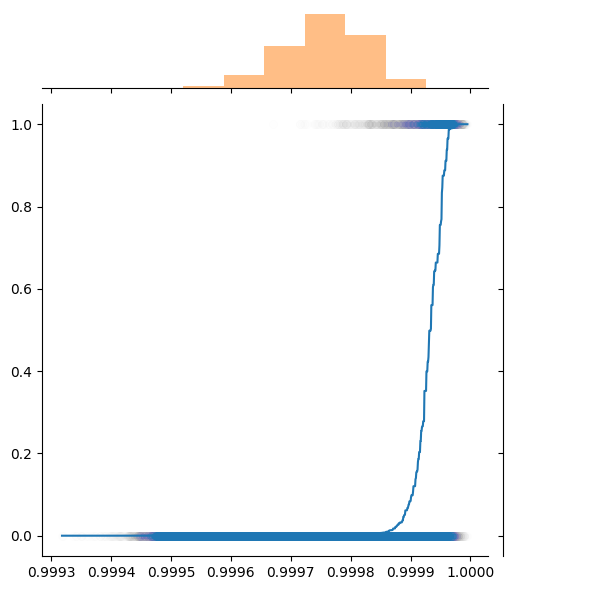

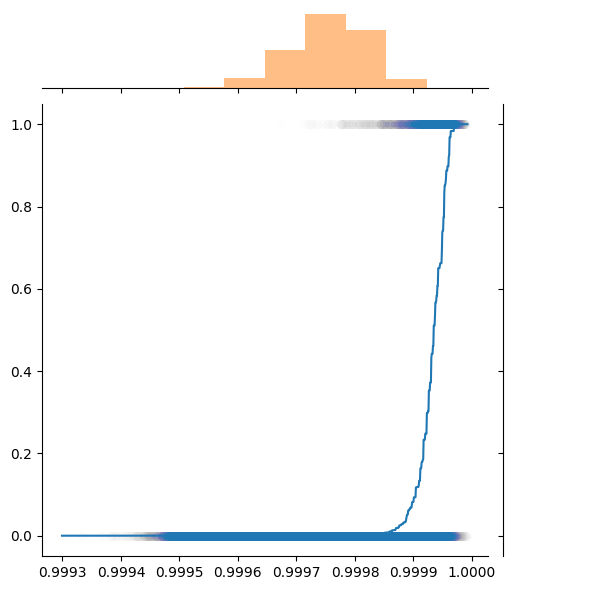

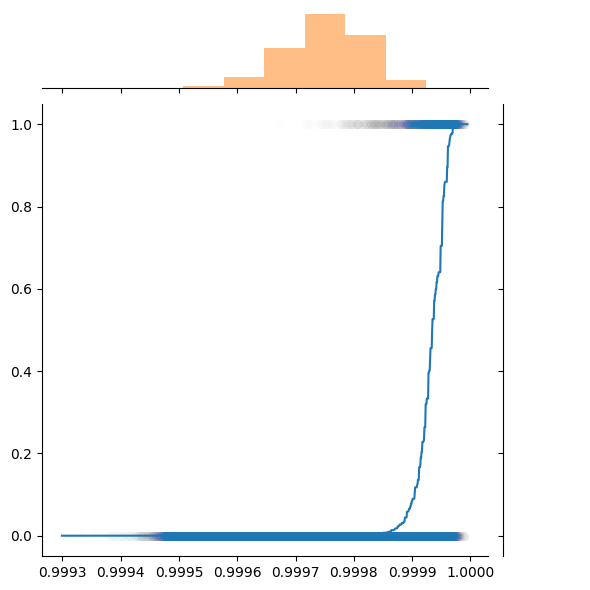

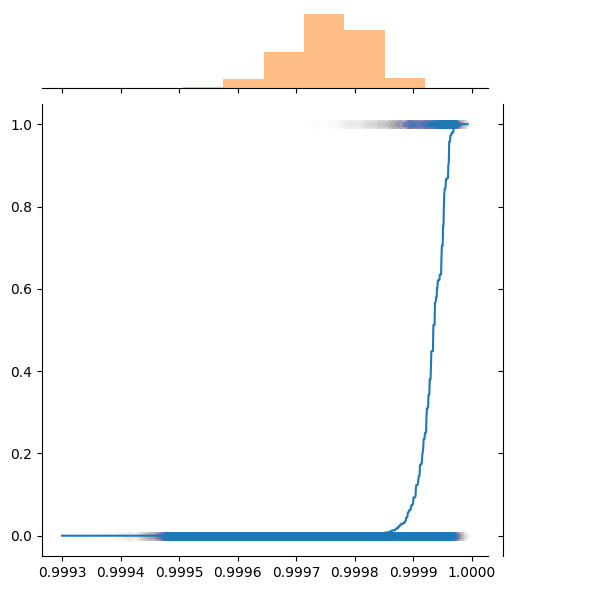

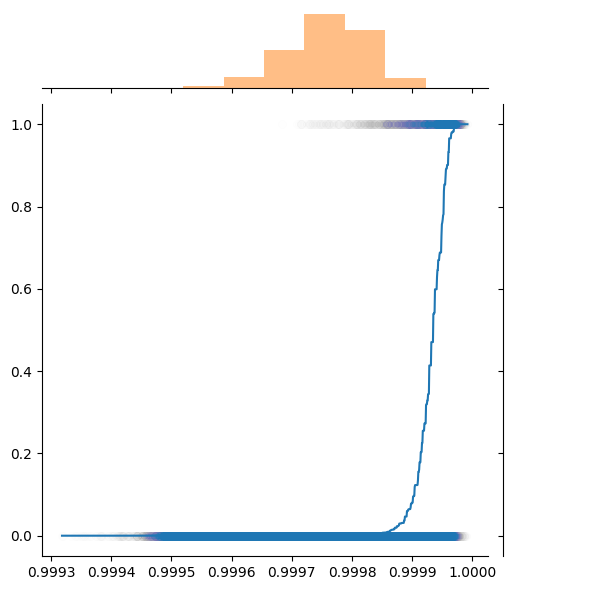

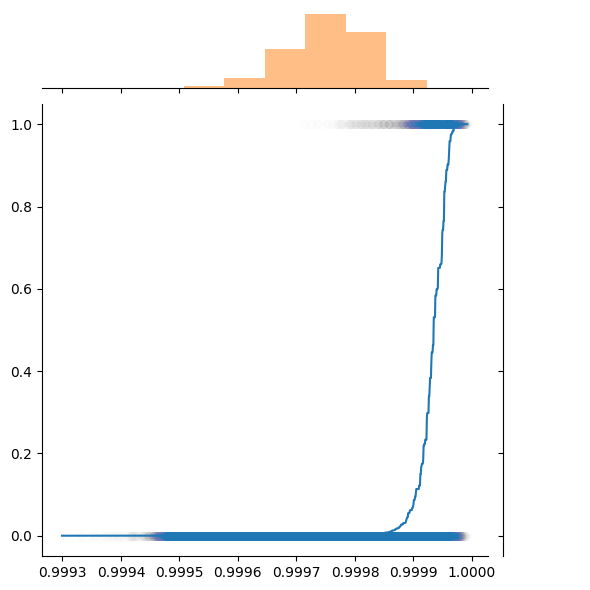

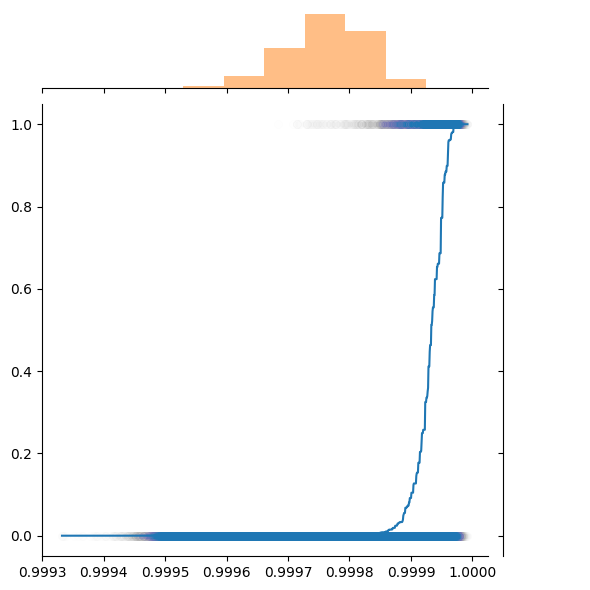

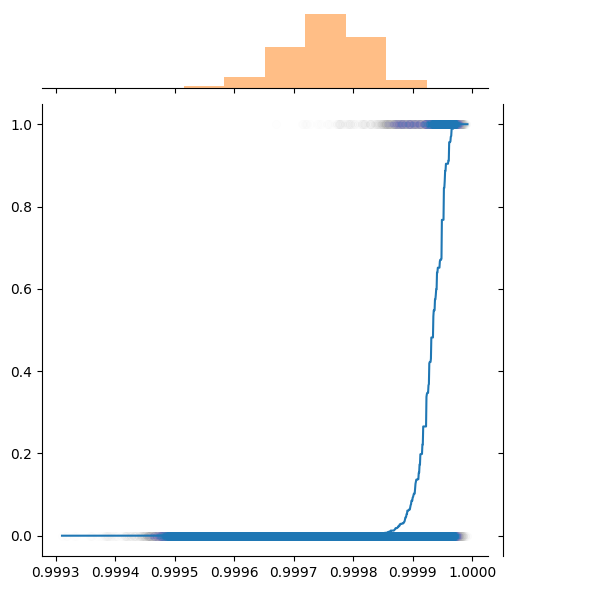

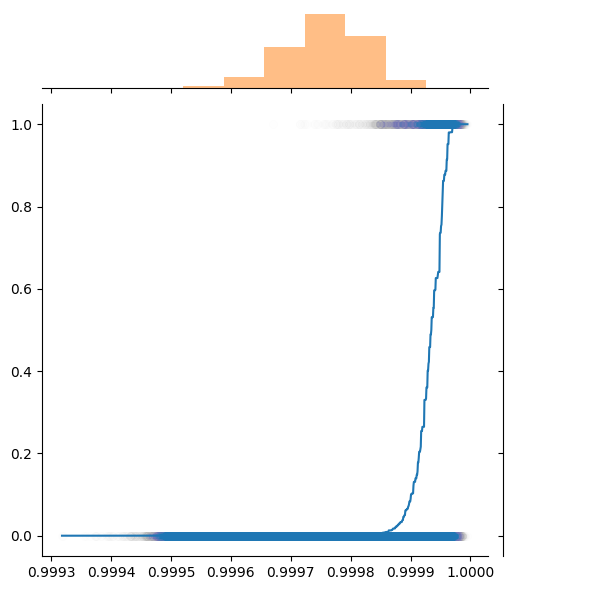

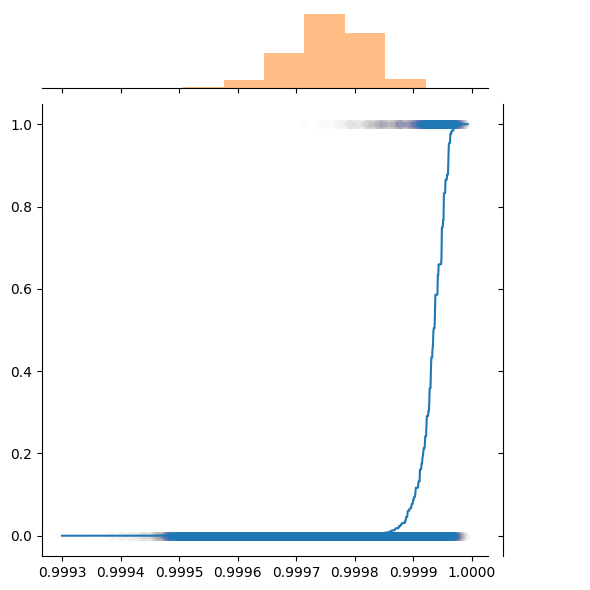

In [10]:
# Full conformal procedure
from scope_utils import get_isotone_regression
import seaborn as sns

num_trials = 10
n_calib = 300 # NOTE: 300 calib, 100 test for now.
for trial in range(num_trials):
    # Randomly split data into calibration and test sets
    np.random.shuffle(near_ids)
    cal_data = near_ids[:n_calib]
    test_data = near_ids[n_calib:]
    ir = get_isotone_regression(cal_data)
    sims, labels = get_sims_labels(test_data, partial=False)
    preds = ir.predict(sims)
    g = sns.JointGrid()
    g.ax_joint.scatter(sims, labels, alpha=0.003)
    x = np.linspace(min(sims), max(sims), 1000)
    phats = ir.predict(x)
    g.ax_joint.plot(x, phats)
    g.ax_marg_x.hist(np.array(sims)[np.array(labels)], label='1', alpha=0.5)
    g.ax_marg_x.hist(np.array(sims)[~np.array(labels)], label='0', alpha=0.5)
    plt.show()
    ##print()
#


### Hierarchical Loss (from 03/08 brainstorm)

In [1]:
from scope_utils import get_sims_labels
import numpy as np
near_ids = np.load('partial_near_ids_scope_test_v_lookup.npy', allow_pickle=True)
sims, _ = get_sims_labels(near_ids, partial=False)
len(sims)

5910800

In [2]:
near_ids[0]['S_i'].shape[0]

14777

In [3]:
## map min(sims), max(sims) to [0,1], and all points in betwßeen linearly
sims, _ = get_sims_labels(near_ids, partial=False)
# do elementwise substracting from list sims


In [4]:
x = np.linspace(min(sims) * near_ids[0]['S_i'].shape[0], max(sims) * near_ids[0]['S_i'].shape[0], 100)
min(x), max(x)

(14766.645575761795, 14776.925133883953)

In [5]:
losses = [np.sum(x['loss']) for x in near_ids]
wc_loss = max(losses)
wc_loss = wc_loss / 14777
wc_loss

3.976855924747919

In [6]:
len(near_ids)

400

In [7]:
alpha = 1 # on average, we want to select lam such that the average loss per query is 1
# wc_loss is just the worst test protein row-wise loss divided by the number of lookup sequences (average loss per retrieval)
loss_thresh = alpha - (wc_loss - alpha)/len(near_ids) # normalize by size of calib set

In [8]:
loss_thresh

0.9925578601881302

In [9]:
for query in near_ids:
    query['Sum_i'] = np.cumsum(query['S_i'])



In [10]:
max(near_ids[0]['Sum_i'])

14775.62

In [11]:
thresh_idx = np.sum(near_ids[0]['S_i'] >= 0.9999)
np.sum(near_ids[0]['loss'][:thresh_idx]) / thresh_idx

0.6190476190476191

In [12]:
(max(sims) - min(sims)) * 14777

10.27955812215805

From above, we can see that setting lambdas using the similarity mass where lambdas are between (min_sim * 14777, max_sim * 14777) doesn't work as there is only roughly a 10-11 protein difference on average using the similarity scores.

### Lets binarize similarities to a valid probability space such that min similarity is 0, and max similarity is 1

In [13]:
sims = np.array(sims)
sims_norm = (sims - min(sims)) / (max(sims) - min(sims))
min(sims_norm), max(sims_norm)


(0.0, 1.0)

In [14]:
sims_norm

array([0.95253192, 0.95038986, 0.94910462, ..., 0.3473567 , 0.28737897,
       0.26989975])

(array([3.300000e+01, 2.720000e+02, 3.828000e+03, 4.346900e+04,
        3.023340e+05, 1.171458e+06, 2.320767e+06, 1.777512e+06,
        2.754400e+05, 1.568700e+04]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

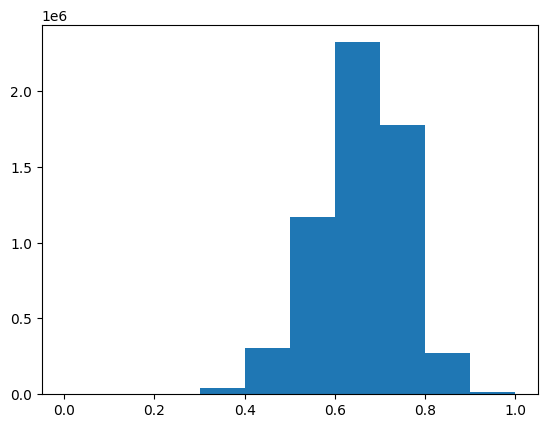

In [15]:
import matplotlib.pyplot as plt
plt.hist(sims_norm)

In [16]:
sims_norm.shape[0] == 400 * 14777

True

In [17]:
## for now lets just try a really wide range of thresholds from min(sims_norm) to max(sims_norm) * 14777 = 14777
x = np.linspace(min(sims_norm)*near_ids[0]['S_i'].shape[0], max(sims_norm)*near_ids[0]['S_i'].shape[0], near_ids[0]['S_i'].shape[0])
#x = np.linspace(min(sims) * near_ids[0]['S_i'].shape[0], max(sims) * near_ids[0]['S_i'].shape[0], 100)
min(x), max(x)

(0.0, 14777.0)

In [18]:
## apply the norm to each row of S_i in near_ids
min_sim, max_sim = min(sims), max(sims)
min_row, max_row = [], []
for query in near_ids:
    query['Norm_S_i'] = (query['S_i'] - min_sim) / (max_sim - min_sim) # normalize each row of S_i
    min_row.append(min(query['Norm_S_i'])) 
    max_row.append(max(query['Norm_S_i']))

    # Now we cumsum the normalized S_i
    query['Sum_Norm_S_i'] = np.cumsum(query['Norm_S_i'])

In [19]:
min(min_row), max(max_row)

(0.0, 1.0)

In [20]:
max(near_ids[0]['Sum_Norm_S_i']) / 14777

0.6477098198424918

In [21]:
near_ids[0]['Sum_Norm_S_i']

array([9.5253193e-01, 1.9029218e+00, 2.8520265e+00, ..., 9.5706680e+03,
       9.5709561e+03, 9.5712080e+03], dtype=float32)

In [22]:
x

array([0.00000000e+00, 1.00006768e+00, 2.00013535e+00, ...,
       1.47749999e+04, 1.47759999e+04, 1.47770000e+04])

In [36]:
losses = []
best_lam = None
# NOTE: don't reverse, because when we do np.linspace with the raw probability mass, the max similarity assumption is more tolerant (and we want our for loop)
# to instead start with the most conservative threshold, (0) and break soon as we find a threshold that is too permissive (wrt to the loss_thresh)

#reversed_x = x[::-1] # reverses x to start with conservative threshold
for lam in x:
    per_lam_losses = []
    for query in near_ids:
        # thresh_idx = np.sum(query['S_i'] >= lam)
        thresh_idx = query['Sum_Norm_S_i'] <= lam # created new attribute where Norm_Sum_i is sum of normalized similarity scores up until Norm_S_i
        # sum over losses of query until thresh_ßßidx
        if np.sum(thresh_idx) == 0:
            loss = 0
        else:
            # get average loss for the confidence set of given threshold
            loss = np.sum(np.asarray(query['loss'])[thresh_idx]) / np.sum(thresh_idx)
            #loss = np.sum(query['loss'][:thresh_idx]) / thresh_idx 
        per_lam_losses.append(loss)
    # average per_lam_losses over all queries
    mean_loss = np.mean(per_lam_losses) # avg over calib
    print(mean_loss)
    if mean_loss > loss_thresh:
        print(mean_loss)
        # best_lam = lam
        break
    best_lam = lam
    losses.append(np.mean(per_lam_losses))

0.0
0.5475
0.625
0.6825


0.76875
0.8330000000000001
0.8988095238095238
0.9469642857142858
0.9985416666666665
0.9985416666666665


In [ ]:
0.9925578601881302

In [24]:
best_lam

7.00047374120195

## todo (DONE)

- functionalize
- custom hierarchical loss/risk function

In [1]:
def get_thresh_hierarchical(data, lambdas, alpha):
    # get the worst case loss
    # NOTE: this is chatgpt-generated, reformat
    wc_loss = max([np.sum(x['loss']) for x in data])
    wc_loss = wc_loss / 14777
    loss_thresh = alpha - (wc_loss - alpha)/len(data) # normalize by size of calib set
    losses = []
    best_lam = None
    for lam in lambdas:
        per_lam_loss = get_hierarchical_loss(data, lam)
        if per_lam_loss > loss_thresh:
            break
        best_lam = lam
        losses.append(per_lam_loss)
    print("worst case loss: " + str(wc_loss))
    print("Loss threshold: " + str(loss_thresh))
    print("Best lambda: " + str(best_lam))
    print("Loss of best lambda: " + str(losses[-1]))

    return best_lam, losses

def get_hierarchical_loss(data_, lambda_):
    losses = []
    for query in data_:
        thresh_idx = query['Sum_Norm_S_i'] <= lambda_
        if np.sum(thresh_idx) == 0:
            loss = 0
        else:
            loss = np.sum(np.asarray(query['loss'])[thresh_idx]) / np.sum(thresh_idx)
        losses.append(loss) # average over all queries
    return np.mean(losses)

In [8]:
near_ids[0]['S_i']

array([0.9999619, 0.9999604, 0.9999595, ..., 0.9995047, 0.9994995,
       0.9994748], dtype=float32)

In [11]:
## testing we reproduce optimal lambda
from scope_utils import get_arbitrary_attribute, get_sims_labels
import numpy as np
near_ids = np.load('partial_near_ids_scope_test_v_lookup.npy', allow_pickle=True)

sims, _ = get_sims_labels(near_ids, partial=False)
sims = np.asarray(sims)
sims_norm = (sims - min(sims)) / (max(sims) - min(sims))

# Define 14777 lambdas from (0, 14777)
x = np.linspace(min(sims_norm)*near_ids[0]['S_i'].shape[0], max(sims_norm)*near_ids[0]['S_i'].shape[0], near_ids[0]['S_i'].shape[0])
min(x), max(x)

(0.0, 14777.0)

In [14]:
near_ids = np.load('partial_near_ids_scope_test_v_lookup.npy', allow_pickle=True)

min_sim, max_sim = min(sims), max(sims)
min_row, max_row = [], []
for query in near_ids:
    query['Norm_S_i'] = (query['S_i'] - min_sim) / (max_sim - min_sim) # normalize each row of S_i
    min_row.append(min(query['Norm_S_i'])) 
    max_row.append(max(query['Norm_S_i']))

    # Now we cumsum the normalized S_i
    query['Sum_Norm_S_i'] = np.cumsum(query['Norm_S_i'])
min(min_row), max(max_row)
best_lam, losses = get_thresh_hierarchical(near_ids, x, alpha = 1)

worst case loss: 3.976855924747919
Loss threshold: 0.9925578601881302
Best lambda: 7.00047374120195
Loss of best lambda: 0.9469642857142858


### Final end-to-end procedure

We will now run the full conformal procedure, randomly shuffling the data into a calibration and test set, before using the best lambda found on calibration to evaluate using hierarchical loss on test. Lets see how far the test loss diverges from the best lambda's loss (which we know is within our threshold of sampling proteins with at least the same superfamily).

In [3]:
from scope_utils import get_sims_labels, get_thresh_hierarchical, get_hierarchical_loss
import numpy as np
near_ids = np.load('partial_near_ids_scope_test_v_lookup.npy', allow_pickle=True)

num_trials = 10
alpha = 1 # max avg. loss we want (on average, each protein retrieved is at most divergent at the family level only)
n_calib = 300 # NOTE: 300 calib, 100 test for now.
for trial in range(num_trials):
    # Randomly split data into calibration and test sets
    np.random.shuffle(near_ids)
    cal_data = near_ids[:n_calib]
    test_data = near_ids[n_calib:]
    # Define lambda linspace, NOTE: for now we want to play around with it so we keep it here, can move it to the get_thresh_hierarchical function later.

    sims, _ = get_sims_labels(cal_data, partial=False)
    sims = np.asarray(sims)

    # Normalize data using min-max scaling
    min_sim, max_sim = min(sims), max(sims)
    min_row, max_row = [], []
    for query in cal_data:
        query['Norm_S_i'] = (query['S_i'] - min_sim) / (max_sim - min_sim) # normalize each row of S_i
        min_row.append(min(query['Norm_S_i'])) 
        max_row.append(max(query['Norm_S_i']))

        # Now we cumsum the normalized S_i
        query['Sum_Norm_S_i'] = np.cumsum(query['Norm_S_i'])
    sims_norm = (sims - min(sims)) / (max(sims) - min(sims))
    x = np.linspace(min(min_row)*cal_data[0]['S_i'].shape[0], max(max_row)*cal_data[0]['S_i'].shape[0], cal_data[0]['S_i'].shape[0])

    lhat, _ = get_thresh_hierarchical(cal_data, x, alpha)
    
    ## perform min-max scaling on test data
    sims, _ = get_sims_labels(test_data, partial=False)
    sims = np.asarray(sims)
    min_sim, max_sim = min(sims), max(sims)
    min_row, max_row = [], []
    for query in test_data:
        query['Norm_S_i'] = (query['S_i'] - min_sim) / (max_sim - min_sim) # normalize each row of S_i
        min_row.append(min(query['Norm_S_i'])) 
        max_row.append(max(query['Norm_S_i']))

        # Now we cumsum the normalized S_i
        query['Sum_Norm_S_i'] = np.cumsum(query['Norm_S_i'])
    sims_norm = (sims - min(sims)) / (max(sims) - min(sims))


    test_loss = get_hierarchical_loss(test_data, lhat)

    print(f'Trial {trial+1}: Lambda: {lhat:.2f}, Test loss: {test_loss:.2f}')
    
    #error, fraction_inexact, error_partial, fraction_partial = validate_lhat(test_data, lhat)
    #print(f'Trial {trial+1}: Ex&!Id/Ex: {error:.2f}, In/Id: {fraction_inexact:.2f}, Pa&!Id/Pa: {error_partial:.2f}, Pa&Id/Id: {fraction_partial:.2f}')


worst case loss: 3.976855924747919
Loss threshold: 0.9900771469175069
Best lambda: 7.00047374120195
Loss of best lambda: 0.9426785714285715
Trial 1: Lambda: 7.00, Test loss: 0.96
worst case loss: 3.976855924747919
Loss threshold: 0.9900771469175069
Best lambda: 7.00047374120195
Loss of best lambda: 0.9476785714285713
Trial 2: Lambda: 7.00, Test loss: 0.94
worst case loss: 3.976855924747919
Loss threshold: 0.9900771469175069
Best lambda: 8.000541418516514
Loss of best lambda: 0.9761111111111113
Trial 3: Lambda: 8.00, Test loss: 1.07
worst case loss: 3.976855924747919
Loss threshold: 0.9900771469175069
Best lambda: 7.00047374120195
Loss of best lambda: 0.9346428571428572
Trial 4: Lambda: 7.00, Test loss: 0.98
worst case loss: 3.976855924747919
Loss threshold: 0.9900771469175069
Best lambda: 7.00047374120195
Loss of best lambda: 0.9688095238095239
Trial 5: Lambda: 7.00, Test loss: 0.88
worst case loss: 3.976855924747919
Loss threshold: 0.9900771469175069
Best lambda: 8.000541418516514
Los